## Imports

In [117]:
import glob
from skimage import io
from skimage import color
from skimage.transform import resize
from matplotlib import pyplot as plt
import cv2
import numpy as np
from sklearn.decomposition import PCA
%load_ext autoreload
%autoreload 2
import predict
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualizing preprocessing

In [118]:
import predict

fnimages = ['data/MYDATA/train/0_0.png', 
            'data/MYDATA/train/100_5.png',
            'data/MYDATA/train/121_6.png', 
            'data/MYDATA/train/200_9.png']

def visualize_pp(version, processed_images, original_images, num=20):
    print('Version ' + str(version) + '...')
    for iprocessed, ioriginal in zip(processed_images[0:num], original_images[0:num]):
        plt.subplot(121)
        plt.title('Original')
        plt.imshow(ioriginal, cmap="Greys_r")
        plt.subplot(122)
        plt.title('Processed')
        plt.imshow(iprocessed, cmap="Greys_r")
        plt.show()

Version 3...


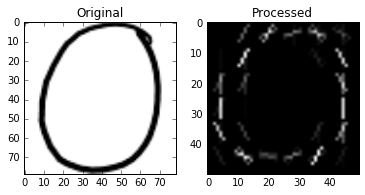

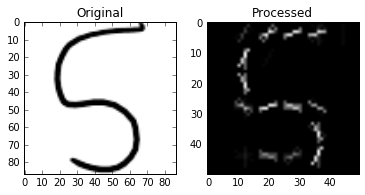

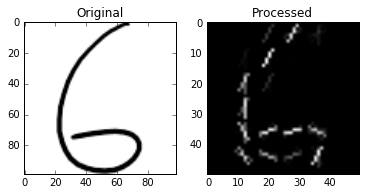

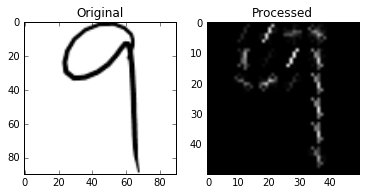

In [120]:


version = 3

images_raw = []
images_proc = []
for fn in fnimages:
    ilabels, iraw = predict.file_to_raw_symbols(fn, True)
    iraw = iraw.squeeze()
    iproc, image_input = predict.preprocess(iraw, version=version)
    images_raw.append(iraw)
    images_proc.append(iproc)
    
visualize_pp(version, images_proc, images_raw, num=20)

## Get training data

In [121]:
X, y, processed_images, original_images = predict.get_custom_data(traindir, version=3)

## Training models and stuff

In [135]:
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import copy

transforms = [
    PCA(n_components=5),
    PCA(n_components=10),
    PCA(n_components=15),
    PCA(n_components=20),
    PCA(n_components=25),
    PCA(n_components=30),
    PCA(n_components=35),
    PCA(n_components=40),
    PCA(n_components=50),
    PCA(n_components=50),
    PCA(n_components=60),
    PCA(n_components=65),
    PCA(n_components=70)
]

models = [
    MLPClassifier(alpha=.001),
    MLPClassifier(),
    MLPClassifier(hidden_layer_sizes=(100,100), alpha=.001),
    MLPClassifier(hidden_layer_sizes=(100,100)),
    SVC(),
    SVC(kernel='linear'),
    KNeighborsClassifier(n_neighbors=5),
    KNeighborsClassifier(n_neighbors=10),
    KNeighborsClassifier(n_neighbors=15),
    SVC(degree=5),
    MLPClassifier(hidden_layer_sizes=(100,100,10), alpha=.001),
    MLPClassifier(hidden_layer_sizes=(100,100,10), alpha=.0001),
    LogisticRegression()
]

strategy_dict = {}

for ts in transforms:
    ts.fit(X)

bscore = 0
for model in models:
    ctransforms = copy.deepcopy(transforms)
    for ts in ctransforms:
        Xts = ts.transform(X)
        score = np.mean(cross_val_score(model, Xts, y, cv=3))
        strategy_dict[(model, ts)] = score
        if(score > bscore):
            bmodel = model
            bts = ts
            bscore = score

In [136]:
print(bscore)
print(bts)
print(bmodel)

0.97603650379
PCA(copy=True, iterated_power='auto', n_components=65, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [130]:
from sklearn.externals import joblib

Xts = bts.transform(X)
bmodel.fit(Xts, y)
print(bmodel.score(Xts, y))

joblib.dump(bmodel, 'models/Model' + str(version) + '.p')
joblib.dump(bts, 'models/Ts' + str(version) + '.p')

1.0


['models/Ts3.p']